# Set Up
We choose the following configurations for the simulation

In [1]:
import numpy as np
import random

In [2]:
def poisson_proc_times(rate: float,
                       time_duration: int
                      ) -> tuple:
    """Source: https://medium.com/@abhash-rai/poisson-process-simulation-and-analysis-in-python-e62f69d1fdd0"""
    num_events = max(np.random.poisson(rate * time_duration), 1)
    event_times = np.sort(np.random.uniform(0, time_duration, num_events))
    inter_arrival_times = np.diff(event_times)
    return num_events, event_times, inter_arrival_times

def num_events_at_time(time: float,
                       event_times: np.array
                      ) -> int:
    """Returns the number of mutations by time according to the Poisson process"""
    return np.sum(event_times <= time)

def generate_mutation_matrices(num_mutations: int,
                               value_range: tuple,
                               n: int
                              ) -> list:
    """Generates random mutation matrices with values from [0,1)"""
    low, high = value_range
    mutation_matrices = []
    
    for k in range(num_mutations):
        M = np.random.uniform(low, high, size=(n,n))
        mutation_matrices.append(M)
    
    return np.array(mutation_matrices)
        

## Interaction and Disturbance Matrices

In [3]:
n = 2    # size of the population state (e.g. how many species there are)
m = 2    # number of strategies

# interaction matrix bewteen species
A = np.array([
    [-0.8,  0.4],
    [ 0.3, -1.0]
])

# matrix mapping environmental effects to disturbance of population state
B = np.array([[1],
              [0]])

# mapping environment and adversarial strategies disturbances
def generate_B_bar(B, n, m, i):
    blocks = [B]
    for j in range(m):
        if j != i:
            blocks.append(np.eye(n))
    return np.concatenate(blocks, axis=1)

B_bar = [generate_B_bar(B, n, m, i) for i in range(m)]

## Mutations

In [4]:
time_length = 500      # years

rate_of_mutations = 0.05

num_mutations, mutation_times, inter_arrival_times = poisson_proc_times(rate_of_mutations, time_length)

mutation_matrices = generate_mutation_matrices(num_mutations, [-1,1], n)

In [5]:
print(f"{num_mutations} mutations have occurred at times: {mutation_times}. \nThese are the mutation matrices \n{mutation_matrices}")

18 mutations have occurred at times: [  0.49175275   6.39128847  23.41668045  26.18813374  66.4850015
  73.03632561  82.09319833  83.08155213 165.26641122 218.33902107
 235.21719017 251.17064227 260.57007749 379.12601916 382.06311241
 382.18751425 474.76251513 483.34155709]. 
These are the mutation matrices 
[[[-0.87953825 -0.0906608 ]
  [-0.41048432 -0.80736716]]

 [[-0.1338474   0.14503652]
  [-0.29097806  0.95154119]]

 [[-0.53823654  0.01647295]
  [-0.58701638 -0.67758348]]

 [[-0.72780579 -0.30404385]
  [ 0.85938851 -0.32070945]]

 [[ 0.03537432 -0.39018915]
  [-0.79372614  0.88322728]]

 [[ 0.80178977 -0.28988655]
  [-0.64125728  0.87323401]]

 [[ 0.51857616 -0.28561992]
  [ 0.56196944 -0.33146492]]

 [[ 0.27160301  0.87569529]
  [-0.57659322 -0.09172471]]

 [[ 0.25300105  0.05524718]
  [-0.78099123 -0.52138535]]

 [[-0.48358     0.02642602]
  [ 0.72968525 -0.63816622]]

 [[-0.95345191  0.42124755]
  [ 0.70073449  0.21616784]]

 [[ 0.53499239 -0.49362862]
  [-0.96823999  0.512289

In [6]:
# get the number of mutations that aren't selected by any strategies
num_unchosen = np.random.randint(low=1, high=num_mutations)

unchosen_indices = np.sort(random.sample(range(num_mutations), k=num_unchosen))

A_neutral = mutation_matrices[unchosen_indices]

print(f"These are the matrices of the {num_unchosen} unchosen mutations are at indices {unchosen_indices}: \n{A_neutral}")

These are the matrices of the 12 unchosen mutations are at indices [ 1  2  6  7  8  9 10 11 13 14 16 17]: 
[[[-0.1338474   0.14503652]
  [-0.29097806  0.95154119]]

 [[-0.53823654  0.01647295]
  [-0.58701638 -0.67758348]]

 [[ 0.51857616 -0.28561992]
  [ 0.56196944 -0.33146492]]

 [[ 0.27160301  0.87569529]
  [-0.57659322 -0.09172471]]

 [[ 0.25300105  0.05524718]
  [-0.78099123 -0.52138535]]

 [[-0.48358     0.02642602]
  [ 0.72968525 -0.63816622]]

 [[-0.95345191  0.42124755]
  [ 0.70073449  0.21616784]]

 [[ 0.53499239 -0.49362862]
  [-0.96823999  0.51228977]]

 [[-0.81940245  0.41134794]
  [ 0.33087092  0.22130849]]

 [[ 0.33654034  0.0575234 ]
  [-0.5815179   0.44106477]]

 [[ 0.90529899 -0.18227999]
  [ 0.09066462 -0.7809381 ]]

 [[-0.93603624  0.10354049]
  [-0.63183178 -0.58272191]]]


## Weighting Matrices
Each list contains the matrices for all $m$ strategies.

In [7]:
Q = [(i+1)*np.eye(2) for i in range(m)]
R = [(i+1)*np.eye(2) for i in range(m)]

# Q1 = np.eye(2)           # penalize deviation from equilibrium
# R1 = 1 * np.eye(2)     # allow strategy to use some effort

# Q2 = np.eye(2) * 2       # second player more strict on deviation
# R2 = 2 * np.eye(2)

# Q = [Q1, Q2]
# R = [R1, R2]

# Solving the Optimization Problem
## We set up the optimization problem in PyMoo as follows:
- Take in the set values for n, m, A, A_neutral, B_bar, Q and R from above
- Take in the user-specified search range for e: e_min and e_max (these are ints used fr each $e_i$)
- Take in the bounds on the matrix W being solved for
    - Note: to guarantee that W is postive semidefinite, it is constructed by multiplying a lower-triangular matrix L by its transpose
- W and e are packed into one vector x to be solved since we are optimizing the upper bound on $e^*$

In [8]:
from numpy.linalg import eigvalsh, inv
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.lhs import LHS
from pymoo.optimize import minimize
from pymoo.termination import get_termination

In [9]:
class EvoGame(ElementwiseProblem):
    """
    Decision vector x packs:
      - W entries of a lower-triangular matrix W = L L^T
      - m scalars: e_1,...,e_m
    Objectives: minimize (e_1,...,e_m)
    Constraints (g<=0):
      - For each i: big block LMI <= 0
      - For each i: [[W, I],[I, e_i I]] >= 0 
      - W > 0
    """
    def __init__(self,
                 n,
                 m,
                 A,
                 A_neutral,
                 B_bar,
                 Q,
                 R,
                 e_min=1e-2,
                 e_max=50,
                 L_range=1.0
                ):
        self.n = n
        self.m = m
        self.A = A
        self.A_neutral = A_neutral
        self.B_bar = B_bar
        self.Q = Q
        self.R = R
        self.e_min = e_min
        self.e_max = e_max
        
        # we construct the matrix W by multiplying a lower-triangular matrix by its transpose
        # to guarantee it is positive semi-definite
        p = n*(n+1)//2   # the number of non-zero entries in a triangular matrix of size nxn
        
        # we add the number of non-zero entries in W with the number of entries in e
        # these are the total number of variables being optimized
        # the variables will be compacted into a decision vector x = (...entries of W..., e_1, ..., e_m)
        n_var = p + m

        # We set up upper and lower bounds for the variables being optimized:
        #  - W entries in [-L_range, L_range]
        #  - e_i in [e_min, e_max]
        xl = np.concatenate([np.full(p, -L_range), np.full(m, e_min)])
        xu = np.concatenate([np.full(p,  L_range), np.full(m, e_max)])

        super().__init__(n_var=n_var, n_obj=m, n_constr=(m + m + 1), xl=xl, xu=xu)

    def unpack(self, x):
        """Unpacks the decision vector x to get the matrix W and vector e"""
        n = self.n
        m = self.m
        p = n*(n+1) // 2
        L = np.zeros((n,n))
        
        # Fill lower-triangular part from x[:p]
        idx = 0
        for r in range(n):
            for c in range(r+1):
                L[r,c] = x[idx]
                idx += 1
        
        W = L @ L.T
        e = np.maximum(x[p:], self.e_min)
        return W, e

    def big_block(self, W, i, e_i):
        """Creates the large matrix used for the linear matrix inequality constraint"""
        A = self.A
        A_neutral = self.A_neutral
        B_i = self.B_bar[i]
        Q_i = self.Q[i]
        R_i = self.R[i]
        
        # Top-left:
        TL = W @ A.T + A @ W - np.linalg.pinv(R_i) + (1.0/e_i)*(B_i @ B_i.T)
        
        for A_k in A_neutral:
            TL += (W @ A_k.T + A_k @ W)
        
        # first row: [ TL, W, (A1 W)^T, ..., (ANrp W)^T ]
        row1 = [TL, W] + [(A_k @ W).T for A_k in A_neutral]
        
        # second row: [ W, -Q_i^{-1}, 0, ..., 0 ]
        row2 = [W, -np.linalg.pinv(Q_i)] + [np.zeros_like(W) for _ in A_neutral]
        rows = [row1, row2]
        
        # next rows for each Ak:
        for k, A_k in enumerate(A_neutral):
            r = [A_k @ W, np.zeros_like(W)]
            for j in range(len(A_neutral)):
                r.append(-W if j == k else np.zeros_like(W))
            rows.append(r)
        
        # fully construct the matrix
        return np.block([[*row] for row in rows])

    def _evaluate(self, x, out, *args, **kwargs):
        """Set up  and run the NSGA-II algorithm to find a Pareto front for W and e"""
        n = self.n
        m = self.m
        W, e = self.unpack(x)

        # Objective: minimize e
        out["F"] = e.copy()

        # Constraints:
        # We set all the constraints in G to be <= 0
        G = []

        # 1. To set the constraints that the big block matrix is negative semi-definite
        #    we use the equivalent idea that its largest eigenvalue should be negative
        #    We do this for all i = 1, ..., m
        #    To ensure that floating-point errors in the values of the matrix don't affect
        #    calculations, we use its symmetric part by calculating (M_i @ M_i.T) / 2
        for i in range(m):
            M_i = self.big_block(W, i, e[i])
            sym_M_i = (M_i + M_i.T) / 2
            max_lambda = eigvalsh(sym_M_i).max()
            G.append(max_lambda)

        # 2. We use the same technique for the constraint: [[W, I],[I, e_i I]] >= 0 
        #    by saying that its minimum lambda should be positive which implies that
        #    - min_lambda <= 0
        I = np.eye(n)
        for i in range(m):
            blk = np.block([[W, I],
                            [I, e[i]*I]])
            sym_blk = (blk + blk.T) / 2
            min_lambda = eigvalsh(sym_blk).min()
            G.append(-min_lambda)

        # 3. We require that W = P^-1 > 0
        #    We use the same technique: - min_lambda(W) <= 0
        sym_W = (W + W.T) / 2
        min_lambda = eigvalsh(sym_W).min()
        G.append(-min_lambda)

        # Set the contraints for the solver
        out["G"] = np.array(G, dtype=float)


### Run the NSGA-II algorithm

In [10]:
problem = EvoGame(n, m, A, A_neutral, B_bar, Q, R, e_min=1e-3, e_max=50, L_range=1.0)

# set up the genetic algorithm with methods
# for the random sampling, crossover and mutation
algo = NSGA2(
    pop_size=100,
    sampling=LHS(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algo,
    termination=get_termination("n_gen", 100),   # stops after 400 generations if not already finished
    seed=42,
    save_history=False,
    verbose=True
)

# Collect the feasible points (all constraints <= 0)
F = res.F
G = res.G
feasible_mask = (G <= 0).all(axis=1)
pareto_F = F[feasible_mask]
pareto_X = res.X[feasible_mask]

print(f"Feasible solutions: {pareto_F.shape[0]}")

# Pick one feasible solution as being the one with smallest max(e_i)
if pareto_F.shape[0] > 0:
    idx = np.argmin(pareto_F.max(axis=1))
    x_best = pareto_X[idx]
    W_best, e_best = problem.unpack(x_best)
    P_best = inv(W_best)
    K_list = [np.linalg.solve(R[i], P_best) for i in range(m)]  # K_i = R_i^{-1} @ P
    
    print("Chosen e:", e_best)
    print("P:\n", P_best)
    
    for i in range(m):
        print(f"K_{i+1}:\n", K_list[i])
else:
    print("No feasible solutions found. Try more generations, larger pop, larger L_range, or easier data.")


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      1 |  0.0905234611 |  2.3070313460 |             - |             -
     2 |      200 |      1 |  0.0104174956 |  0.6500398166 |             - |             -
     3 |      300 |      1 |  0.000000E+00 |  0.3067307489 |             - |             -
     4 |      400 |      1 |  0.000000E+00 |  0.1412094727 |  0.000000E+00 |             f
     5 |      500 |      1 |  0.000000E+00 |  0.0651243880 |  0.000000E+00 |             f
     6 |      600 |      6 |  0.000000E+00 |  0.0302288077 |  0.3214265803 |         ideal
     7 |      700 |      7 |  0.000000E+00 |  0.0124454898 |  0.0149793561 |             f
     8 |      800 |      9 |  0.000000E+00 |  0.0011630903 |  0.1372774159 |         ideal
     9 |      900 |      7 |  0.000000E+00 |  0.000000E+00 |  1.5761235850 |         nadir
    10 |     1000 |      7 |  0.000000E+00 |  0.000000E+00 |  0.2233967800 |         ideal

    89 |     8900 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0044630997 |             f
    90 |     9000 |      7 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    91 |     9100 |      7 |  0.000000E+00 |  0.000000E+00 |  0.1173766959 |         ideal
    92 |     9200 |      7 |  0.000000E+00 |  0.000000E+00 |  0.7794098528 |         ideal
    93 |     9300 |     11 |  0.000000E+00 |  0.000000E+00 |  0.2866339570 |         nadir
    94 |     9400 |     14 |  0.000000E+00 |  0.000000E+00 |  0.0008890264 |             f
    95 |     9500 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0113580153 |             f
    96 |     9600 |     12 |  0.000000E+00 |  0.000000E+00 |  0.1462115943 |         ideal
    97 |     9700 |     11 |  0.000000E+00 |  0.000000E+00 |  0.7364286166 |         nadir
    98 |     9800 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0081882801 |         ideal
    99 |     9900 |     13 |  0.000000E+00 |  0.000000E+00 |  0.2908885177 |         ideal

# Calculating deviation from equilibrium point
1. We calculate $u_i^*(t) = -R_i^{-1}P\tilde{x}(t)$ and $\bar{v}_i^*(t) = \frac{1}{e_i}\bar{B}_i^TP\tilde{x}(t)$ for an initial $x(0)$
2. We then calculate the rate of change of the deviation of the population state from the point of equilibrium for a strategy $i$ using:
$$\dot{\tilde{x}}(t) = A\tilde{x}(t) + \sum_{k=1}^{N_r(t)} A_kp(t - t_k)\tilde{x}(t) + u_i(t) + \bar{B}_i\bar{v}_i(t) \qquad (1)$$
3. We calculate the next population state as: $\tilde{x}(t+\Delta{t}) = \tilde{x}(t) + \Delta{t}\dot{\tilde{x}}(t) = \tilde{x}(t) + \dot{\tilde{x}}(t)$ (we let $\Delta{t} = 1$ for simplicity)

In [11]:
# times = range(100)
# dt = 1.0
T = 500
dt = 0.1
times = np.arange(0, T, dt)
x_0 = np.array([-0.001, 0.002])

pop_states = [[x_0.copy()] for _ in range(m)]        # [[x(0), x(1), ...], ..., [x(0), x(1), ...]] for all strategies

# for each strategy
for strategy, (K_i, e_i, B_i) in enumerate(zip(K_list, e_best, B_bar)):
    x_t = x_0.copy()          # initial single copy x(0) = (x_1, ..., x_n) to be used for all strategies

    for time in times:
        # get mutations that occured up until now
        num_mutations_so_far = num_events_at_time(time, mutation_times)
        A_neutral_so_far = A_neutral[:num_mutations_so_far]
    
        u = - (K_i @ x_t)
        v = (1/e_i) * B_i.T @ P_best @ x_t

        x_dot_t = A @ x_t + np.sum([A_k @ x_t for A_k in A_neutral_so_far]) + u + B_i @ v

        new_x_t = x_t + dt * x_dot_t
        
        print(f'--------------- Strategy {strategy} ---------------')
        print(f'time: {time:.1f}')
        print(f'    x({time:.1f}): {x_t}')
        print(f'    {num_mutations_so_far} mutations occurred so far.')
        print(f'    K_i: {K_i.tolist()}')
        print(f'    u = {u}')
        print(f'    v = {v}')
        print(f'    Rate of Change: {x_dot_t}')

        x_t = new_x_t.copy()
        
        pop_states[strategy].append(new_x_t) # pop_states[strategy][time]

--------------- Strategy 0 ---------------
time: 0.0
    x(0.0): [-0.001  0.002]
    0 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [ 0.01293279 -0.01231894]
    v = [-0.00106789 -0.00106789  0.0010172 ]
    Rate of Change: [ 0.01239701 -0.01360173]
--------------- Strategy 0 ---------------
time: 0.1
    x(0.1): [0.0002397  0.00063983]
    0 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0.00261355 -0.00369776]
    v = [0.00021581 0.00021581 0.00030533]
    Rate of Change: [-0.00211776 -0.00396035]
--------------- Strategy 0 ---------------
time: 0.2
    x(0.2): [2.79245530e-05 2.43791874e-04]
    0 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0.00023091 -0.00143651]
    v = [1.90666457e-05 1.90666457e-05 1.18616176e-04]
    Rate of

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-4.53589103e-21 -8.01245429e-21]
    v = [3.74539375e-22 3.74539375e-22 6.61607521e-22]
    Rate of Change: [-2.24362540e-21 -7.27075193e-21]
--------------- Strategy 0 ---------------
time: 5.5
    x(5.5): [2.01341376e-22 6.52472199e-22]
    1 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-2.14529984e-21 -3.78957889e-21]
    v = [1.77142540e-22 1.77142540e-22 3.12914595e-22]
    Rate of Change: [-1.06114745e-21 -3.43878255e-21]
--------------- Strategy 0 ---------------
time: 5.6
    x(5.6): [9.52266309e-23 3.08593944e-22]
    1 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.01464329e-21 -1.79232325e-21]
    v = [8.37815239e-23 8.37815239e-23 1.47996419e-22]
    Rate of Change: [-5.01881425e-22 -1.62641025e-21]
--

--------------- Strategy 0 ---------------
time: 11.9
    x(11.9): [1.51677200e-48 7.90066264e-48]
    2 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.48637177e-47 -4.62876943e-47]
    v = [1.22733273e-48 1.22733273e-48 3.82208567e-48]
    Rate of Change: [-9.37284098e-48 -4.88218759e-47]
--------------- Strategy 0 ---------------
time: 12.0
    x(12.0): [5.79487907e-49 3.01847505e-48]
    2 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-5.67873394e-48 -1.76843712e-47]
    v = [4.68906648e-49 4.68906648e-49 1.46024084e-48]
    Rate of Change: [-3.58092580e-48 -1.86525639e-47]
--------------- Strategy 0 ---------------
time: 12.1
    x(12.1): [2.21395327e-49 1.15321867e-48]
    2 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-2.16957

    2 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-3.07911208e-82 -9.58878537e-82]
    v = [2.54249651e-83 2.54249651e-83 7.91768949e-83]
    Rate of Change: [-1.94164263e-82 -1.01137569e-81]
--------------- Strategy 0 ---------------
time: 20.3
    x(20.3): [1.20044544e-83 6.25295985e-83]
    2 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.17638525e-82 -3.66342808e-82]
    v = [9.71369446e-84 9.71369446e-84 3.02498022e-83]
    Rate of Change: [-7.41811174e-83 -3.86399526e-82]
--------------- Strategy 0 ---------------
time: 20.4
    x(20.4): [4.58634266e-84 2.38896459e-83]
    2 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-4.49441988e-83 -1.39962517e-82]
    v = [3.71115003e-84 3.71115003e-84 1.15570399e-83]
    Rate of Change:

--------------- Strategy 0 ---------------
time: 26.4
    x(26.4): [2.14326199e-110 9.80196523e-110]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-2.15950237e-109 -5.73132286e-109]
    v = [1.78315278e-110 1.78315278e-110 4.73249041e-110]
    Rate of Change: [-1.15783049e-109 -5.74954881e-109]
--------------- Strategy 0 ---------------
time: 26.5
    x(26.5): [9.85431505e-111 4.05241643e-110]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.01264581e-109 -2.36517706e-109]
    v = [8.36165872e-111 8.36165872e-111 1.95298329e-110]
    Rate of Change: [-5.94375942e-110 -2.37778287e-109]
--------------- Strategy 0 ---------------
time: 26.6
    x(26.6): [3.91055563e-111 1.67463355e-110]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633

    Rate of Change: [-3.84843065e-139 -1.62899670e-138]
--------------- Strategy 0 ---------------
time: 34.2
    x(34.2): [2.71097342e-140 1.14752406e-139]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-2.77163615e-139 -6.70093376e-139]
    v = [2.28860628e-140 2.28860628e-140 5.53312133e-140]
    Rate of Change: [-1.59053979e-139 -6.73257312e-139]
--------------- Strategy 0 ---------------
time: 34.3
    x(34.3): [1.12043362e-140 4.74266744e-140]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.14550527e-139 -2.76946703e-139]
    v = [9.45871108e-141 9.45871108e-141 2.28681518e-140]
    Rate of Change: [-6.57363238e-140 -2.78254344e-139]
--------------- Strategy 0 ---------------
time: 34.4
    x(34.4): [4.63070385e-141 1.96012400e-140]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.43

--------------- Strategy 0 ---------------
time: 40.2
    x(40.2): [2.56317170e-163 1.08496128e-162]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-2.62052712e-162 -6.33560022e-162]
    v = [2.16383194e-163 2.16383194e-163 5.23145668e-163]
    Rate of Change: [-1.50382389e-162 -6.36551461e-162]
--------------- Strategy 0 ---------------
time: 40.3
    x(40.3): [1.05934781e-163 4.48409818e-163]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.08305256e-162 -2.61847625e-162]
    v = [8.94302409e-164 8.94302409e-164 2.16213849e-163]
    Rate of Change: [-6.21523928e-163 -2.63083974e-162]
--------------- Strategy 0 ---------------
time: 40.4
    x(40.4): [4.37823882e-164 1.85325844e-163]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633

    x(42.6): [1.58138886e-172 6.69383828e-172]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.61677518e-171 -3.90884763e-171]
    v = [1.33500995e-172 1.33500995e-172 3.22762901e-172]
    Rate of Change: [-9.27807664e-172 -3.92730378e-171]
--------------- Strategy 0 ---------------
time: 42.7
    x(42.7): [6.53581197e-173 2.76653449e-172]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-6.68206211e-172 -1.61550987e-171]
    v = [5.51753856e-173 5.51753856e-173 1.33396515e-172]
    Rate of Change: [-3.83458907e-172 -1.62313772e-171]
--------------- Strategy 0 ---------------
time: 42.8
    x(42.8): [2.70122290e-173 1.14339678e-172]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-2.76166746e-172 -6.67683262e-172]
    v =

    x(44.9): [2.36068901e-181 9.99252671e-181]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-2.41351352e-180 -5.83510726e-180]
    v = [1.99289586e-181 1.99289586e-181 4.81818767e-181]
    Rate of Change: [-1.38502642e-180 -5.86265851e-180]
--------------- Strategy 0 ---------------
time: 45.0
    x(45.0): [9.75662587e-182 4.12986820e-181]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-9.97494731e-181 -2.41162467e-180]
    v = [8.23655265e-182 8.23655265e-182 1.99133619e-181]
    Rate of Change: [-5.72425447e-181 -2.42301148e-180]
--------------- Strategy 0 ---------------
time: 45.1
    x(45.1): [4.03237140e-182 1.70685672e-181]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-4.12260271e-181 -9.96714076e-181]
    v =

time: 47.1
    x(47.1): [8.52664154e-190 3.60922989e-189]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-8.71743995e-189 -2.10759943e-188]
    v = [7.19819874e-190 7.19819874e-190 1.74029527e-189]
    Rate of Change: [-5.00261736e-189 -2.11755074e-188]
--------------- Strategy 0 ---------------
time: 47.2
    x(47.2): [3.52402418e-190 1.49167915e-189]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-3.60288034e-189 -8.71061754e-189]
    v = [2.97498450e-190 2.97498450e-190 7.19256531e-190]
    Rate of Change: [-2.06756018e-189 -8.75174591e-189]
--------------- Strategy 0 ---------------
time: 47.3
    x(47.3): [1.45646400e-190 6.16504561e-190]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.48905491e-189 -3.60006067e-1

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-9.93907059e-214 -2.40295082e-213]
    v = [8.20692838e-215 8.20692838e-215 1.98417398e-214]
    Rate of Change: [-5.70366614e-214 -2.41429668e-213]
--------------- Strategy 0 ---------------
time: 53.7
    x(53.7): [4.01786824e-215 1.70071770e-214]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-4.10777502e-214 -9.93129211e-214]
    v = [3.39188811e-215 3.39188811e-215 8.20050551e-215]
    Rate of Change: [-2.35730062e-214 -9.97818406e-214]
--------------- Strategy 0 ---------------
time: 53.8
    x(53.8): [1.66056762e-215 7.02899290e-215]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.6977257e-214 -4.1045602e-214]
    v = [1.40185273e-215 1.40185273e-215 3.38923356e-215]
    Rate of Change: [-9.7426218

    u = [-1.36649157e-240 -3.30374153e-240]
    v = [1.12834478e-241 1.12834478e-241 2.72797842e-241]
    Rate of Change: [-7.84179125e-241 -3.31934059e-240]
--------------- Strategy 0 ---------------
time: 60.7
    x(60.7): [5.52404071e-242 2.33826329e-241]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-5.64765072e-241 -1.36542213e-240]
    v = [4.66340032e-242 4.66340032e-242 1.12746172e-241]
    Rate of Change: [-3.24097851e-241 -1.37186915e-240]
--------------- Strategy 0 ---------------
time: 60.8
    x(60.8): [2.28306221e-242 9.66394133e-242]
    4 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-2.33414969e-241 -5.64323077e-241]
    v = [1.92736324e-242 1.92736324e-242 4.65975067e-242]
    Rate of Change: [-1.33948244e-241 -5.66987605e-241]
--------------- Strategy 0 ---------------
time: 60.9
    x(60.9): [

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-7.45287210e-265 -3.48752809e-264]
    v = [6.15401480e-266 6.15401480e-266 2.87973538e-265]
    Rate of Change: [-4.79047973e-265 -3.79512889e-264]
--------------- Strategy 0 ---------------
time: 66.9
    x(66.9): [3.52403154e-266 2.13482043e-265]
    5 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-3.32335804e-265 -1.25322602e-264]
    v = [2.74417625e-266 2.74417625e-266 1.03481871e-265]
    Rate of Change: [-2.37073284e-265 -1.36947567e-264]
--------------- Strategy 0 ---------------
time: 67.0
    x(67.0): [1.15329871e-266 7.65344763e-266]
    5 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.05863969e-265 -4.49766832e-265]
    v = [8.74144119e-267 8.74144119e-267 3.71383234e-266]
    Rate of Change: [-7.15904

--------------- Strategy 0 ---------------
time: 69.6
    x(69.6): [3.24587689e-278 2.08108096e-277]
    5 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-3.01116251e-277 -1.22250217e-276]
    v = [2.48638893e-278 2.48638893e-278 1.00944929e-277]
    Rate of Change: [-2.08042828e-277 -1.33385829e-276]
--------------- Strategy 0 ---------------
time: 69.7
    x(69.7): [1.16544860e-278 7.47222677e-278]
    5 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.08117322e-277 -4.38945606e-277]
    v = [8.92750599e-279 8.92750599e-279 3.62447889e-278]
    Rate of Change: [-7.46988380e-278 -4.78928584e-277]
--------------- Strategy 0 ---------------
time: 69.8
    x(69.8): [4.18460224e-279 2.68294092e-278]
    5 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.06440234e-298 -2.31355456e-297]
    v = [8.78902481e-300 8.78902481e-300 1.91035736e-298]
    Rate of Change: [-1.60927141e-298 -2.71681223e-297]
--------------- Strategy 0 ---------------
time: 74.2
    x(74.2): [6.81865103e-300 1.19340881e-298]
    6 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-3.03873352e-299 -7.06177990e-298]
    v = [2.50915497e-300 2.50915497e-300 5.83108062e-299]
    Rate of Change: [-4.70404956e-299 -8.29115371e-298]
--------------- Strategy 0 ---------------
time: 74.3
    x(74.3): [2.11460147e-300 3.64293438e-299]
    6 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-9.67610783e-300 -2.15549606e-298]
    v = [7.98979374e-301 7.98979374e-301 1.77984467e-299]
    Rate of Change: [-1.47550

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-4.07317323e-312 -9.22047895e-311]
    v = [3.36331659e-313 3.36331659e-313 7.61357008e-312]
    Rate of Change: [-6.24645900e-312 -1.08264153e-310]
--------------- Strategy 0 ---------------
time: 76.8
    x(76.8): [2.74428456e-313 4.75641795e-312]
    6 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-1.24327249e-312 -2.81440806e-311]
    v = [1.02659984e-313 1.02659984e-313 2.32392407e-312]
    Rate of Change: [-1.90663424e-312 -3.30459521e-311]
--------------- Strategy 0 ---------------
time: 76.9
    x(76.9): [8.37650324e-314 1.45182274e-312]
    6 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-3.79489704e-313 -8.59054369e-312]
    v = [3.13353728e-314 3.13353728e-314 7.09341746e-313]
    Rate of Change: [-5.81970

    x(80.6): [0. 0.]
    6 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 80.7
    x(80.7): [0. 0.]
    6 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 80.8
    x(80.8): [0. 0.]
    6 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 80.9
    x(80.9): [0. 0.]
    6 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate o

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 88.4
    x(88.4): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 88.5
    x(88.5): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 88.6
    x(88.6): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------

--------------- Strategy 0 ---------------
time: 92.1
    x(92.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 92.2
    x(92.2): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 92.3
    x(92.3): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 92.4
    x(92.4): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.94215161613

    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 98.0
    x(98.0): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 98.1
    x(98.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 98.2
    x(98.2): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
---

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 102.9
    x(102.9): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 103.0
    x(103.0): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 103.1
    x(103.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 106.9
    x(106.9): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 107.0
    x(107.0): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 107.1
    x(107.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 112.4
    x(112.4): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 112.5
    x(112.5): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 112.6
    x(112.6): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

time: 117.8
    x(117.8): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 117.9
    x(117.9): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 118.0
    x(118.0): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 118.1
    x(118.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 122.3
    x(122.3): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 122.4
    x(122.4): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 122.5
    x(122.5): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 126.1
    x(126.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 126.2
    x(126.2): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 126.3
    x(126.3): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 126.4
    x(126.4): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 130.0
    x(130.0): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 130.1
    x(130.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 130.2
    x(130.2): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 134.6
    x(134.6): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 134.7
    x(134.7): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 134.8
    x(134.8): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

--------------- Strategy 0 ---------------
time: 140.2
    x(140.2): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 140.3
    x(140.3): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 140.4
    x(140.4): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 140.5
    x(140.5): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 143.4
    x(143.4): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 143.5
    x(143.5): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 143.6
    x(143.6): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

time: 146.4
    x(146.4): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 146.5
    x(146.5): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 146.6
    x(146.6): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 146.7
    x(146.7): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0

--------------- Strategy 0 ---------------
time: 150.6
    x(150.6): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 150.7
    x(150.7): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 150.8
    x(150.8): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 150.9
    x(150.9): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942

    x(154.8): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 154.9
    x(154.9): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 155.0
    x(155.0): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 155.1
    x(155.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
   

--------------- Strategy 0 ---------------
time: 162.9
    x(162.9): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 163.0
    x(163.0): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 163.1
    x(163.1): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 163.2
    x(163.2): [0. 0.]
    8 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942

    x(169.6): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 169.7
    x(169.7): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 169.8
    x(169.8): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 169.9
    x(169.9): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
   

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 179.1
    x(179.1): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 179.2
    x(179.2): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 179.3
    x(179.3): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 183.3
    x(183.3): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 183.4
    x(183.4): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 183.5
    x(183.5): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 191.0
    x(191.0): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 191.1
    x(191.1): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 191.2
    x(191.2): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 198.0
    x(198.0): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 198.1
    x(198.1): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 198.2
    x(198.2): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 198.3
    x(198.3): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.0

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 207.5
    x(207.5): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 207.6
    x(207.6): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 207.7
    x(207.7): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 217.0
    x(217.0): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 217.1
    x(217.1): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 217.2
    x(217.2): [0. 0.]
    9 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 222.5
    x(222.5): [0. 0.]
    10 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 222.6
    x(222.6): [0. 0.]
    10 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 222.7
    x(222.7): [0. 0.]
    10 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 

    10 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 228.4
    x(228.4): [0. 0.]
    10 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 228.5
    x(228.5): [0. 0.]
    10 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 228.6
    x(228.6): [0. 0.]
    10 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [

time: 237.0
    x(237.0): [0. 0.]
    11 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 237.1
    x(237.1): [0. 0.]
    11 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 237.2
    x(237.2): [0. 0.]
    11 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 237.3
    x(237.3): [0. 0.]
    11 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v 

    11 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 246.5
    x(246.5): [0. 0.]
    11 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 246.6
    x(246.6): [0. 0.]
    11 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 246.7
    x(246.7): [0. 0.]
    11 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [

--------------- Strategy 0 ---------------
time: 253.7
    x(253.7): [0. 0.]
    12 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 253.8
    x(253.8): [0. 0.]
    12 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 253.9
    x(253.9): [0. 0.]
    12 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 254.0
    x(254.0): [0. 0.]
    12 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 258.6
    x(258.6): [0. 0.]
    12 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 258.7
    x(258.7): [0. 0.]
    12 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 258.8
    x(258.8): [0. 0.]
    12 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 258.9
    x(258.9): [0. 0.]
    12 mutations occurred so far.
    K_i: [[12.063524177983995

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 265.3
    x(265.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 265.4
    x(265.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 265.5
    x(265.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 265.6
    x(265.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995

    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 271.8
    x(271.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 271.9
    x(271.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 272.0
    x(272.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [

    x(277.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 277.7
    x(277.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 277.8
    x(277.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 277.9
    x(277.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]

--------------- Strategy 0 ---------------
time: 283.7
    x(283.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 283.8
    x(283.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 283.9
    x(283.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 284.0
    x(284.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5

--------------- Strategy 0 ---------------
time: 290.5
    x(290.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 290.6
    x(290.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 290.7
    x(290.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 290.8
    x(290.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5

    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 295.5
    x(295.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 295.6
    x(295.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 295.7
    x(295.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 295.8
    x(295.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[

    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 302.8
    x(302.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 302.9
    x(302.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 303.0
    x(303.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 

--------------- Strategy 0 ---------------
time: 314.3
    x(314.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 314.4
    x(314.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 314.5
    x(314.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 314.6
    x(314.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5

    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 322.3
    x(322.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 322.4
    x(322.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 322.5
    x(322.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 322.6
    x(322.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[

--------------- Strategy 0 ---------------
time: 329.0
    x(329.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 329.1
    x(329.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 329.2
    x(329.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 329.3
    x(329.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5

    x(332.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 332.5
    x(332.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 332.6
    x(332.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 332.7
    x(332.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]

--------------- Strategy 0 ---------------
time: 340.9
    x(340.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 341.0
    x(341.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 341.1
    x(341.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 341.2
    x(341.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5

time: 349.7
    x(349.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 349.8
    x(349.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 349.9
    x(349.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 350.0
    x(350.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v 

    x(357.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 357.1
    x(357.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 357.2
    x(357.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 357.3
    x(357.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]

    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 362.8
    x(362.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 362.9
    x(362.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 363.0
    x(363.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 363.1
    x(363.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.43463418281187

--------------- Strategy 0 ---------------
time: 369.7
    x(369.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 369.8
    x(369.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 369.9
    x(369.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 370.0
    x(370.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5

--------------- Strategy 0 ---------------
time: 379.0
    x(379.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 379.1
    x(379.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 379.2
    x(379.2): [0. 0.]
    14 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 379.3
    x(379.3): [0. 0.]
    14 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5

time: 386.2
    x(386.2): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 386.3
    x(386.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 386.4
    x(386.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 386.5
    x(386.5): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v 

    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 396.6
    x(396.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 396.7
    x(396.7): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 396.8
    x(396.8): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [

time: 406.4
    x(406.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 406.5
    x(406.5): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 406.6
    x(406.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 406.7
    x(406.7): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v 

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 412.8
    x(412.8): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 412.9
    x(412.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 413.0
    x(413.0): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 413.1
    x(413.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995

    x(421.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 421.4
    x(421.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 421.5
    x(421.5): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 421.6
    x(421.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]

    x(431.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 431.7
    x(431.7): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 431.8
    x(431.8): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 431.9
    x(431.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]

    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 442.9
    x(442.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 443.0
    x(443.0): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 443.1
    x(443.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 443.2
    x(443.2): [0. 0.]
    16 mutations occurred so far.
    K_i: [[

time: 451.3
    x(451.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 451.4
    x(451.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 451.5
    x(451.5): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 451.6
    x(451.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v 

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 459.3
    x(459.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 459.4
    x(459.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 459.5
    x(459.5): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 459.6
    x(459.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 465.3
    x(465.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 465.4
    x(465.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 465.5
    x(465.5): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 465.6
    x(465.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995

    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 473.6
    x(473.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 473.7
    x(473.7): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 473.8
    x(473.8): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 473.9
    x(473.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[12.063524177983995, -0.43463418281187

    x(482.7): [0. 0.]
    17 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 482.8
    x(482.8): [0. 0.]
    17 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 482.9
    x(482.9): [0. 0.]
    17 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 483.0
    x(483.0): [0. 0.]
    17 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]

    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 489.7
    x(489.7): [0. 0.]
    18 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 489.8
    x(489.8): [0. 0.]
    18 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 489.9
    x(489.9): [0. 0.]
    18 mutations occurred so far.
    K_i: [[12.063524177983995, -0.4346341828118745], [-0.4346341828118745, 5.942151616134633]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 0 ---------------
time: 490.0
    x(490.0): [0. 0.]
    18 mutations occurred so far.
    K_i: [[

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [ 0.00102872 -0.00240553]
    v = [-0.00017011 -0.00017011  0.00039779]
    Rate of Change: [ 0.0011216  -0.00284954]
--------------- Strategy 1 ---------------
time: 0.3
    x(0.3): [-2.95927421e-05  5.14326144e-04]
    0 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [ 0.00029027 -0.00153453]
    v = [-4.80005110e-05 -4.80005110e-05  2.53759648e-04]
    Rate of Change: [ 0.00042367 -0.00180398]
--------------- Strategy 1 ---------------
time: 0.4
    x(0.4): [1.27744450e-05 3.33928415e-04]
    0 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.48406103e-06 -9.89350529e-04]
    v = [7.41511436e-07 7.41511436e-07 1.63604984e-04]
    Rate of Change: [ 0.00012035 -0.00115584]
--------------- Strategy 1 -------------

--------------- Strategy 1 ---------------
time: 4.2
    x(4.2): [6.01979520e-09 1.06698393e-08]
    1 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-3.39912340e-08 -3.03926971e-08]
    v = [5.62099592e-09 5.62099592e-09 5.02592011e-09]
    Rate of Change: [-1.41541969e-08 -2.50877321e-08]
--------------- Strategy 1 ---------------
time: 4.3
    x(4.3): [4.60437551e-09 8.16106612e-09]
    1 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.59989585e-08 -2.32465366e-08]
    v = [4.29934493e-09 4.29934493e-09 3.84418781e-09]
    Rate of Change: [-1.08261553e-08 -1.91889150e-08]
--------------- Strategy 1 ---------------
time: 4.4
    x(4.4): [3.52175998e-09 6.24217462e-09]
    1 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.98858

    Rate of Change: [-1.53169563e-19 -4.67251998e-19]
--------------- Strategy 1 ---------------
time: 11.1
    x(11.1): [2.98042758e-20 9.09195478e-20]
    2 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.60013929e-19 -2.63651890e-19]
    v = [2.64608706e-20 2.64608706e-20 4.35990703e-20]
    Rate of Change: [-1.01174274e-19 -3.08637569e-19]
--------------- Strategy 1 ---------------
time: 11.2
    x(11.2): [1.96868484e-20 6.00557908e-20]
    2 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.05695236e-19 -1.74152019e-19]
    v = [1.74784031e-20 1.74784031e-20 2.87988305e-20]
    Rate of Change: [-6.68294244e-20 -2.03866757e-19]
--------------- Strategy 1 ---------------
time: 11.3
    x(11.3): [1.30039060e-20 3.96691152e-20]
    2 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [

time: 20.7
    x(20.7): [1.52915113e-37 4.66475783e-37]
    2 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-8.20974420e-37 -1.35270385e-36]
    v = [1.35761293e-37 1.35761293e-37 2.23691285e-37]
    Rate of Change: [-5.19089128e-37 -1.58350933e-36]
--------------- Strategy 1 ---------------
time: 20.8
    x(20.8): [1.0100620e-37 3.0812485e-37]
    2 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-5.42284572e-37 -8.93511915e-37]
    v = [8.96754547e-38 8.96754547e-38 1.47756531e-37]
    Rate of Change: [-3.42877949e-37 -1.04596764e-36]
--------------- Strategy 1 ---------------
time: 20.9
    x(20.9): [6.67184051e-38 2.03528086e-37]
    2 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-3.58199415e-37 -5.90198323e-37]
    v = [5.923

    Rate of Change: [-3.56817100e-49 -8.13571021e-49]
--------------- Strategy 1 ---------------
time: 27.5
    x(27.5): [8.32623835e-50 1.89269611e-49]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.61087367e-49 -5.44240022e-49]
    v = [7.62481941e-50 7.62481941e-50 8.99988198e-50]
    Rate of Change: [-2.49974567e-49 -5.69013624e-49]
--------------- Strategy 1 ---------------
time: 27.6
    x(27.6): [5.82649267e-50 1.32368248e-49]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-3.22674293e-49 -3.80614135e-49]
    v = [5.33593716e-50 5.33593716e-50 6.29406541e-50]
    Rate of Change: [-1.75015316e-49 -3.97957375e-49]
--------------- Strategy 1 ---------------
time: 27.7
    x(27.7): [4.07633951e-50 9.25725106e-50]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.53528337e-58 -5.34321027e-58]
    v = [7.49981872e-59 7.49981872e-59 8.83585549e-59]
    Rate of Change: [-2.46194590e-58 -5.58713814e-58]
--------------- Strategy 1 ---------------
time: 33.4
    x(33.4): [5.72658083e-59 1.29958981e-58]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-3.17171423e-58 -3.73673147e-58]
    v = [5.24493838e-59 5.24493838e-59 6.17928503e-59]
    Rate of Change: [-1.72174222e-58 -3.90732048e-58]
--------------- Strategy 1 ---------------
time: 33.5
    x(33.5): [4.00483861e-59 9.08857767e-59]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.21811304e-58 -2.61325334e-58]
    v = [3.66800580e-59 3.66800580e-59 4.32143368e-59]
    Rate of Change: [-1.20408668e-58 -2.732553

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.70519616e-70 -2.00896414e-70]
    v = [2.81981545e-71 2.81981545e-71 3.32214454e-71]
    Rate of Change: [-9.25653452e-71 -2.10067724e-70]
--------------- Strategy 1 ---------------
time: 41.4
    x(41.4): [2.15310552e-71 4.88625602e-71]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.19251533e-70 -1.40495304e-70]
    v = [1.97201543e-71 1.97201543e-71 2.32331528e-71]
    Rate of Change: [-6.47348355e-71 -1.46909186e-70]
--------------- Strategy 1 ---------------
time: 41.5
    x(41.5): [1.50575717e-71 3.41716416e-71]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-8.33976081e-71 -9.82542700e-71]
    v = [1.37911326e-71 1.37911326e-71 1.62479200e-71]
    Rate of Change: [-4.52717907e-71 -1.027397

    Rate of Change: [-1.52017903e-80 -3.44989312e-80]
--------------- Strategy 1 ---------------
time: 47.7
    x(47.7): [3.53599487e-81 8.02458405e-81]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.95844005e-80 -2.30732154e-80]
    v = [3.23859485e-81 3.23859485e-81 3.81552637e-81]
    Rate of Change: [-1.06312507e-80 -2.41265523e-80]
--------------- Strategy 1 ---------------
time: 47.8
    x(47.8): [2.47286980e-81 5.61192883e-81]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.36961942e-80 -1.61360691e-80]
    v = [2.26488547e-81 2.26488547e-81 2.66835792e-81]
    Rate of Change: [-7.43488037e-81 -1.68727118e-80]
--------------- Strategy 1 ---------------
time: 47.9
    x(47.9): [1.72938176e-81 3.92465765e-81]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.51854129e-93 -2.96720063e-93]
    v = [4.16481211e-94 4.16481211e-94 4.90674232e-94]
    Rate of Change: [-1.36717199e-93 -3.10265907e-93]
--------------- Strategy 1 ---------------
time: 56.1
    x(56.1): [3.18009462e-94 7.21690430e-94]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.76132175e-93 -2.07508809e-93]
    v = [2.91262812e-94 2.91262812e-94 3.43149109e-94]
    Rate of Change: [-9.56120823e-94 -2.16981986e-93]
--------------- Strategy 1 ---------------
time: 56.2
    x(56.2): [2.22397380e-94 5.04708443e-94]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.23176631e-93 -1.45119629e-93]
    v = [2.03692323e-94 2.03692323e-94 2.39978591e-94]
    Rate of Change: [-6.68655468e-94 -1.517446

    x(64.7): [1.39877450e-107 3.17437778e-107]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-7.74722845e-107 -9.12733941e-107]
    v = [1.28112853e-107 1.28112853e-107 1.50935202e-107]
    Rate of Change: [-4.20552714e-107 -9.54402008e-107]
--------------- Strategy 1 ---------------
time: 64.8
    x(64.8): [9.78221784e-108 2.21997577e-107]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-5.41796240e-107 -6.38313199e-107]
    v = [8.95947011e-108 8.95947011e-108 1.05555329e-107]
    Rate of Change: [-2.94110185e-107 -6.67453429e-107]
--------------- Strategy 1 ---------------
time: 64.9
    x(64.9): [6.84111599e-108 1.55252234e-107]
    4 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-3.78900877e-107 -4.46399242e-107]
 

    v = [7.25414846e-120 7.25414846e-120 1.53483488e-119]
    Rate of Change: [-2.99817006e-119 -1.13423687e-118]
--------------- Strategy 1 ---------------
time: 71.4
    x(71.4): [5.42223893e-120 2.05128568e-119]
    5 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.82478609e-119 -5.97669075e-119]
    v = [4.67123702e-120 4.67123702e-120 9.88341710e-120]
    Rate of Change: [-1.93064190e-119 -7.30380594e-119]
--------------- Strategy 1 ---------------
time: 71.5
    x(71.5): [3.49159703e-120 1.32090509e-119]
    5 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.81899301e-119 -3.84863079e-119]
    v = [3.00799679e-120 3.00799679e-120 6.36432851e-120]
    Rate of Change: [-1.24321772e-119 -4.70321346e-119]
--------------- Strategy 1 ---------------
time: 71.6
    x(71.6): [2.24837931e-120 8.50583744e-120]
    5 m

--------------- Strategy 1 ---------------
time: 78.0
    x(78.0): [6.40784249e-135 1.75690630e-133]
    6 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.70004747e-136 -5.20597646e-133]
    v = [7.77228259e-137 7.77228259e-137 8.60891736e-134]
    Rate of Change: [-2.54792407e-134 -6.98591409e-133]
--------------- Strategy 1 ---------------
time: 78.1
    x(78.1): [3.85991842e-135 1.05831489e-133]
    6 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.83118252e-136 -3.13594550e-133]
    v = [4.68181455e-137 4.68181455e-137 5.18578904e-134]
    Rate of Change: [-1.53480348e-134 -4.20813387e-133]
--------------- Strategy 1 ---------------
time: 78.2
    x(78.2): [2.32511494e-135 6.37501502e-134]
    6 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080

    u = [-3.64032493e-148 -8.45656846e-148]
    v = [6.01986135e-149 6.01986135e-149 1.39842928e-148]
    Rate of Change: [-2.55371723e-148 -1.04540817e-147]
--------------- Strategy 1 ---------------
time: 85.2
    x(85.2): [4.52568549e-149 1.85267203e-148]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.32716852e-148 -5.40607817e-148]
    v = [3.84834654e-149 3.84834654e-149 8.93981764e-149]
    Rate of Change: [-1.63252648e-148 -6.68303911e-148]
--------------- Strategy 1 ---------------
time: 85.3
    x(85.3): [2.89315902e-149 1.18436812e-148]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.48770125e-148 -3.45597418e-148]
    v = [2.46015272e-149 2.46015272e-149 5.71500780e-149]
    Rate of Change: [-1.04363342e-148 -4.27230399e-148]
--------------- Strategy 1 ---------------
time: 85.4
    x(85.4

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.71180664e-164 -6.29961289e-164]
    v = [4.48440738e-165 4.48440738e-165 1.04174207e-164]
    Rate of Change: [-1.90235148e-164 -7.78763319e-164]
--------------- Strategy 1 ---------------
time: 93.5
    x(93.5): [3.37134767e-165 1.38012450e-164]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.73359206e-164 -4.02718938e-164]
    v = [2.86677263e-165 2.86677263e-165 6.65960379e-165]
    Rate of Change: [-1.21612706e-164 -4.97844458e-164]
--------------- Strategy 1 ---------------
time: 93.6
    x(93.6): [2.15522061e-165 8.82280046e-165]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.10824326e-164 -2.57448427e-164]
    v = [1.83265805e-165 1.83265805e-165 4.25732281e-165]
    Rate of Change: [-7

time: 101.4
    x(101.4): [1.50373243e-180 6.15581120e-180]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-7.73239328e-180 -1.79625950e-179]
    v = [1.27867529e-180 1.27867529e-180 2.97040328e-180]
    Rate of Change: [-5.42432842e-180 -2.22055074e-179]
--------------- Strategy 1 ---------------
time: 101.5
    x(101.5): [9.61299589e-181 3.93526046e-180]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.94313106e-180 -1.14830503e-179]
    v = [8.17426031e-181 8.17426031e-181 1.89890661e-180]
    Rate of Change: [-3.46764130e-180 -1.41954411e-179]
--------------- Strategy 1 ---------------
time: 101.6
    x(101.6): [6.14535459e-181 2.51571635e-180]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-3.16002352e-180 -7

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-6.56622291e-198 -1.52535442e-197]
    v = [1.08583031e-198 1.08583031e-198 2.52241827e-198]
    Rate of Change: [-4.60625169e-198 -1.88565566e-197]
--------------- Strategy 1 ---------------
time: 110.8
    x(110.8): [8.16320013e-199 3.34175933e-198]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.19762669e-198 -9.75122001e-198]
    v = [6.94144922e-199 6.94144922e-199 1.61252068e-198]
    Rate of Change: [-2.94466473e-198 -1.20545383e-197]
--------------- Strategy 1 ---------------
time: 110.9
    x(110.9): [5.2185354e-199 2.1363055e-198]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.68344070e-198 -6.23371791e-198]
    v = [4.43749975e-199 4.43749975e-199 1.03084527e-198]
    Rate of Change: [

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.19690320e-213 -2.78044411e-213]
    v = [1.97927148e-214 1.97927148e-214 4.59791045e-214]
    Rate of Change: [-8.39636035e-214 -3.43720785e-213]
--------------- Strategy 1 ---------------
time: 118.9
    x(118.9): [1.48800314e-214 6.09142041e-214]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-7.65151119e-214 -1.77747033e-213]
    v = [1.26530014e-214 1.26530014e-214 2.93933238e-214]
    Rate of Change: [-5.36758906e-214 -2.19732342e-213]
--------------- Strategy 1 ---------------
time: 119.0
    x(119.0): [9.51244238e-215 3.89409699e-214]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.89142510e-214 -1.13629357e-213]
    v = [8.08875622e-215 8.08875622e-215 1.87904374e-214]
    Rate of Change:

    u = [-2.32939631e-230 -5.41126156e-230]
    v = [3.85203055e-231 3.85203055e-231 8.94838920e-231]
    Rate of Change: [-1.63408794e-230 -6.68944598e-230]
--------------- Strategy 1 ---------------
time: 127.5
    x(127.5): [2.89593097e-231 1.18550375e-230]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.48912644e-230 -3.45928797e-230]
    v = [2.46250949e-231 2.46250949e-231 5.72048769e-231]
    Rate of Change: [-1.0446327e-230 -4.2764002e-230]
--------------- Strategy 1 ---------------
time: 127.6
    x(127.6): [1.85129827e-231 7.57863726e-231]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-9.51962331e-231 -2.21143871e-230]
    v = [1.57422245e-231 1.57422245e-231 3.65696872e-231]
    Rate of Change: [-6.67808290e-231 -2.73379869e-230]
--------------- Strategy 1 ---------------
time: 127.7
    x(1

--------------- Strategy 1 ---------------
time: 134.3
    x(134.3): [1.77249549e-244 7.25604326e-244]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-9.11440886e-244 -2.11730610e-243]
    v = [1.50721374e-244 1.50721374e-244 3.50130536e-244]
    Rate of Change: [-6.39382210e-244 -2.61743119e-243]
--------------- Strategy 1 ---------------
time: 134.4
    x(134.4): [1.13311328e-244 4.63861207e-244]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-5.82662002e-244 -1.35354232e-243]
    v = [9.63525106e-245 9.63525106e-245 2.23829940e-244]
    Rate of Change: [-4.08741504e-244 -1.67326013e-243]
--------------- Strategy 1 ---------------
time: 134.5
    x(134.5): [7.24371772e-245 2.96535193e-244]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710

    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.13396866e-260 -2.63424519e-260]
    v = [1.87519912e-261 1.87519912e-261 4.35614708e-261]
    Rate of Change: [-7.95487014e-261 -3.25647554e-260]
--------------- Strategy 1 ---------------
time: 143.1
    x(143.1): [1.40976224e-261 5.77112658e-261]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-7.24918600e-261 -1.68400891e-260]
    v = [1.19876922e-261 1.19876922e-261 2.78477893e-261]
    Rate of Change: [-5.08535511e-261 -2.08178565e-260]
--------------- Strategy 1 ---------------
time: 143.2
    x(143.2): [9.01226731e-262 3.68934093e-261]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.63422839e-261 -1.07654596e-260]
    v = [7.66344018e-262 7.66344018e-262 1.7

--------------- Strategy 1 ---------------
time: 152.0
    x(152.0): [7.16794726e-279 2.93433387e-278]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-3.68585435e-278 -8.56235663e-278]
    v = [6.09515155e-279 6.09515155e-279 1.41592305e-278]
    Rate of Change: [-2.58565282e-278 -1.05848556e-277]
--------------- Strategy 1 ---------------
time: 152.1
    x(152.1): [4.58229443e-279 1.87584831e-278]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.35627709e-278 -5.47370645e-278]
    v = [3.89648222e-279 3.89648222e-279 9.05165185e-279]
    Rate of Change: [-1.65294499e-278 -6.76664086e-278]
--------------- Strategy 1 ---------------
time: 152.2
    x(152.2): [2.92934944e-279 1.19918422e-278]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710

    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-4.29506524e-294 -9.97757286e-294]
    v = [7.10257950e-295 7.10257950e-295 1.64995176e-294]
    Rate of Change: [-3.01301856e-294 -1.23343575e-293]
--------------- Strategy 1 ---------------
time: 160.3
    x(160.3): [5.33967207e-295 2.18589508e-294]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.74573080e-294 -6.37841978e-294]
    v = [4.54050642e-295 4.54050642e-295 1.05477405e-294]
    Rate of Change: [-1.92614952e-294 -7.88505492e-294]
--------------- Strategy 1 ---------------
time: 160.4
    x(160.4): [3.41352255e-295 1.39738959e-294]
    8 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.75527895e-294 -4.07756871e-294]
    v = [2.90263538e-295 2.90263538e-295 6.7

    u = [-1.45541910e-306 -2.15254591e-306]
    v = [2.40676900e-307 2.40676900e-307 3.55958003e-307]
    Rate of Change: [-8.83896048e-307 -2.45326139e-306]
--------------- Strategy 1 ---------------
time: 167.0
    x(167.0): [1.79712325e-307 4.98784474e-307]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-9.75587596e-307 -1.44287192e-306]
    v = [1.61329062e-307 1.61329062e-307 2.38602023e-307]
    Rate of Change: [-5.92491287e-307 -1.64444642e-306]
--------------- Strategy 1 ---------------
time: 167.1
    x(167.1): [1.20463196e-307 3.34339832e-307]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-6.53947579e-307 -9.67170274e-307]
    v = [1.08140725e-307 1.08140725e-307 1.59937123e-307]
    Rate of Change: [-3.97154972e-307 -1.10228824e-306]
--------------- Strategy 1 ---------------
time: 167.2
    x

--------------- Strategy 1 ---------------
time: 174.3
    x(174.3): [3.7381e-320 1.0375e-319]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-2.02928e-319 -3.00125e-319]
    v = [3.3557e-320 3.3557e-320 4.9629e-320]
    Rate of Change: [-1.2325e-319 -3.4206e-319]
--------------- Strategy 1 ---------------
time: 174.4
    x(174.4): [2.5054e-320 6.9545e-320]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-1.36006e-319 -2.01179e-319]
    v = [2.249e-320 2.249e-320 3.327e-320]
    Rate of Change: [-8.25930e-320 -2.29276e-319]
--------------- Strategy 1 ---------------
time: 174.5
    x(174.5): [1.6793e-320 4.6615e-320]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-9.11650e-320 -1.34845e-319]
    v = [1.5074e-320 1.5

    x(180.8): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 180.9
    x(180.9): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 181.0
    x(181.0): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 181.1
    x(181.1): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.0317

--------------- Strategy 1 ---------------
time: 190.3
    x(190.3): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 190.4
    x(190.4): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 190.5
    x(190.5): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 190.6
    x(190.6): [0.e+000 5.e-

    x(199.6): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 199.7
    x(199.7): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 199.8
    x(199.8): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 199.9
    x(199.9): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.0317

time: 206.2
    x(206.2): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 206.3
    x(206.3): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 206.4
    x(206.4): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 206.5
    x(206.5): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K

    x(214.4): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 214.5
    x(214.5): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 214.6
    x(214.6): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 214.7
    x(214.7): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.0317

    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 218.3
    x(218.3): [0.e+000 5.e-324]
    9 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 218.4
    x(218.4): [0.e+000 5.e-324]
    10 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 218.5
    x(218.5): [0.e+000 5.e-324]
    10 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strat

    x(226.7): [0.e+000 5.e-324]
    10 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 226.8
    x(226.8): [0.e+000 5.e-324]
    10 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 226.9
    x(226.9): [0.e+000 5.e-324]
    10 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0.0e+000 -1.5e-323]
    v = [0. 0. 0.]
    Rate of Change: [ 0.e+000 -2.e-323]
--------------- Strategy 1 ---------------
time: 227.0
    x(227.0): [0.e+000 5.e-324]
    10 mutations occurred so far.
    K_i: [[6.

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 235.7
    x(235.7): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 235.8
    x(235.8): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 235.9
    x(235.9): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Str

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 246.0
    x(246.0): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 246.1
    x(246.1): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 246.2
    x(246.2): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Str

    x(250.5): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 250.6
    x(250.6): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 250.7
    x(250.7): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 250.8
    x(250.8): [0. 0.]
    11 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0

    12 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 257.6
    x(257.6): [0. 0.]
    12 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 257.7
    x(257.7): [0. 0.]
    12 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 257.8
    x(257.8): [0. 0.]
    12 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of C

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 264.4
    x(264.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 264.5
    x(264.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 264.6
    x(264.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Str

    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 271.2
    x(271.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 271.3
    x(271.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 271.4
    x(271.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 271.5
    x(271.5): [0. 0.]
    13 mutations occurred so far.
    K

    x(278.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 278.3
    x(278.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 278.4
    x(278.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 278.5
    x(278.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 290.2
    x(290.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 290.3
    x(290.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 290.4
    x(290.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Str

--------------- Strategy 1 ---------------
time: 298.9
    x(298.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 299.0
    x(299.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 299.1
    x(299.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 299.2
    x(299.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 305.6
    x(305.6): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 305.7
    x(305.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 305.8
    x(305.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 305.9
    x(305.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.0317620889

--------------- Strategy 1 ---------------
time: 311.2
    x(311.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 311.3
    x(311.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 311.4
    x(311.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 311.5
    x(311.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 317.9
    x(317.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 318.0
    x(318.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 318.1
    x(318.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of C

    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 322.2
    x(322.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 322.3
    x(322.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 322.4
    x(322.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 322.5
    x(322.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.217317091

time: 328.2
    x(328.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 328.3
    x(328.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 328.4
    x(328.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 328.5
    x(328.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 336.9
    x(336.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 337.0
    x(337.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 337.1
    x(337.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 337.2
    x(337.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.0317620889

    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 343.2
    x(343.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 343.3
    x(343.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 343.4
    x(343.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 343.5
    x(343.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.0317620889

time: 349.2
    x(349.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 349.3
    x(349.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 349.4
    x(349.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 349.5
    x(349.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.

--------------- Strategy 1 ---------------
time: 357.2
    x(357.2): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 357.3
    x(357.3): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 357.4
    x(357.4): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 357.5
    x(357.5): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 366.7
    x(366.7): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 366.8
    x(366.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 366.9
    x(366.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Str

    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 373.8
    x(373.8): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 373.9
    x(373.9): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 374.0
    x(374.0): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 374.1
    x(374.1): [0. 0.]
    13 mutations occurred so far.
    K_i: [[6.031762088991997, -0.217317091

time: 381.4
    x(381.4): [0. 0.]
    14 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 381.5
    x(381.5): [0. 0.]
    14 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 381.6
    x(381.6): [0. 0.]
    14 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 381.7
    x(381.7): [0. 0.]
    14 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.

--------------- Strategy 1 ---------------
time: 388.6
    x(388.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 388.7
    x(388.7): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 388.8
    x(388.8): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 388.9
    x(388.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 397.1
    x(397.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 397.2
    x(397.2): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 397.3
    x(397.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 397.4
    x(397.4): [0. 0.]
    16 mutations occurred so far.
    K

--------------- Strategy 1 ---------------
time: 406.9
    x(406.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 407.0
    x(407.0): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 407.1
    x(407.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 407.2
    x(407.2): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

--------------- Strategy 1 ---------------
time: 415.3
    x(415.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 415.4
    x(415.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 415.5
    x(415.5): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 415.6
    x(415.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

--------------- Strategy 1 ---------------
time: 421.8
    x(421.8): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 421.9
    x(421.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 422.0
    x(422.0): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 422.1
    x(422.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

time: 429.1
    x(429.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 429.2
    x(429.2): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 429.3
    x(429.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 429.4
    x(429.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.

    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 436.6
    x(436.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 436.7
    x(436.7): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 436.8
    x(436.8): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 436.9
    x(436.9): [0. 0.]
    16 mutations occurred so far.
    K

--------------- Strategy 1 ---------------
time: 446.7
    x(446.7): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 446.8
    x(446.8): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 446.9
    x(446.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 447.0
    x(447.0): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

--------------- Strategy 1 ---------------
time: 453.4
    x(453.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 453.5
    x(453.5): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 453.6
    x(453.6): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 453.7
    x(453.7): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

--------------- Strategy 1 ---------------
time: 460.1
    x(460.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 460.2
    x(460.2): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 460.3
    x(460.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 460.4
    x(460.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

--------------- Strategy 1 ---------------
time: 465.9
    x(465.9): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 466.0
    x(466.0): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 466.1
    x(466.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 466.2
    x(466.2): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 473.1
    x(473.1): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 473.2
    x(473.2): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 473.3
    x(473.3): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 473.4
    x(473.4): [0. 0.]
    16 mutations occurred so far.
    K_i: [[6.031762088991997, -0.217317091

--------------- Strategy 1 ---------------
time: 481.0
    x(481.0): [0. 0.]
    17 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 481.1
    x(481.1): [0. 0.]
    17 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 481.2
    x(481.2): [0. 0.]
    17 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 481.3
    x(481.3): [0. 0.]
    17 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.2173170914059

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 488.5
    x(488.5): [0. 0.]
    18 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 488.6
    x(488.6): [0. 0.]
    18 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 488.7
    x(488.7): [0. 0.]
    18 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Str

    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 497.8
    x(497.8): [0. 0.]
    18 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 497.9
    x(497.9): [0. 0.]
    18 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Strategy 1 ---------------
time: 498.0
    x(498.0): [0. 0.]
    18 mutations occurred so far.
    K_i: [[6.031762088991997, -0.21731709140593725], [-0.21731709140593725, 2.9710758080673165]]
    u = [-0. -0.]
    v = [0. 0. 0.]
    Rate of Change: [0. 0.]
--------------- Str

# Results
We show how the population rate changes over time for a number of steps where $\Delta{t} = 1$.


In [12]:
import matplotlib.pyplot as plt

times_arr = np.arange(0, len(times) + 1)
pop_states = np.array(pop_states)

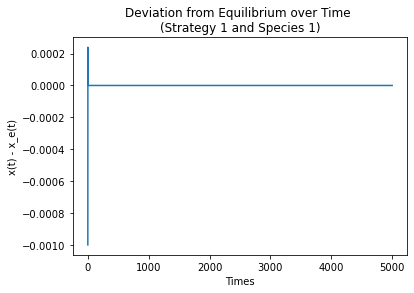

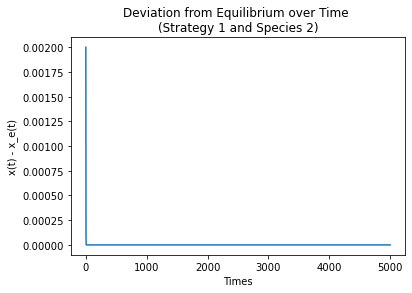

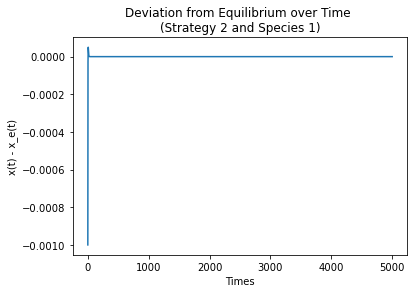

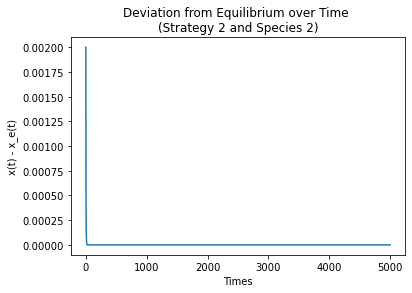

In [13]:
for i in range(m):
    for j in range(n):
        plt.xlabel("Times")
        plt.ylabel("x(t) - x_e(t)")
        plt.title(f"Deviation from Equilibrium over Time \n(Strategy {i+1} and Species {j+1})")

        plt.plot(times_arr, pop_states[i, :, j])

        plt.show()